$\newcommand{\Rset}{\mathbb{R}}$
# Minimization in $SE(3)\times \Rset^3$
$\newcommand{\mapcom}[5]{\begin{align*} #1 \,:\, #2& \longrightarrow #3 \\ #4& \longmapsto #5, \end{align*}}$
$\newcommand{\mapdot}[5]{\begin{align*} #1 \,:\, #2& \longrightarrow #3 \\ #4& \longmapsto #5. \end{align*}}$
$\newcommand{\mani}[1]{\mathcal{#1}}$
$\newcommand{\atan}{\operatorname{arctan}}$
$\newcommand{\argmin}{\operatorname{argmin}}$

As a second example, let us consider a tangent $SE(3)$ parameterization of a parabolic curve 
$$
    \mathcal{C}(t) = \tau_y(at^2) \cdot \tau_x(t) \cdot \rho_z (\atan(2 at))
$$
Consider two points $P_1 \simeq (R_1, \tau_1), P_2 \simeq (R_1, \tau_1) \in SE(3)$ such that $\|\tau_1 - \tau_2 \|_2 = h$, $h\in\Rset$.


We want to find $(\varphi, t)\in SE(3) \times \Rset^2$ such that 
$$
    \begin{cases}
        \varphi \cdot C(t_1) = P_1\cdot\rho_z(\theta - \frac{\pi}{2})\\
        \varphi \cdot C(t_2) = P_2\cdot\rho_z(t_3)
    \end{cases}
$$
with $t=(t_1, t_2)$. Now let us re-write the problem as 
$$
    \begin{cases}
        \varphi\cdot E_1(t_1;\theta, a) = I\\
        \varphi\cdot E_2(t_2, t_3; a) = I
    \end{cases},
$$
and consider $\mathcal{S} = SE(3)\times \Rset^3$. Then we consider the map $$\mapcom{f}{\mathcal{S} \times \mathcal{P}}{\Rset}{(\varphi, t, \mu)}{ \| \varphi\cdot E_1(t_1;\theta, a) - I\|^2_F + \| \varphi\cdot E_2(t_2, t_3; a) - I\|^2_F}$$

for $t=(t_1, t_2, t_3)$ and $\mu=(a, \theta)$.

For a given $\mu\in\mathcal{P}$, we aim at solving the following minimization problem
$$
    \text{find } (\varphi^*, t^*)\in SE(3)\times \Rset^3 \text{ s.t. }  (\varphi^*, t^*) = \argmin_{(\varphi, t)\in SE(3)\times \Rset^3} f(\varphi, t;\mu) 
$$



In [1]:
import autograd.numpy as np

In [2]:
from pymanopt.manifolds import Product
from pymanopt.manifolds import Rotations
from pymanopt.manifolds import Euclidean

# Dimension of the sphere 
solutionSpaceDimension = 9

# Instantiate the SE(3) manifold
euclideanSpace = Euclidean(3)
rotationSpace = Rotations(3)
specialEuclideanGroup = Product((rotationSpace, euclideanSpace))

# Instantiate the solution space 
n = 3
Rn = Euclidean(n)
solutionSpace = Product((rotationSpace, euclideanSpace, Rn))

In [3]:
# Dimension of the parameter space 
parameterSpaceDimension = 2

# Instantiate the parameter space 
parameterSpace = Euclidean(2)

# Instantiate the global manifold
product = Product((rotationSpace, euclideanSpace, Rn, parameterSpace))

## Define the parabolic SE(3)-parameterization 

In [4]:
def rho_z(theta):
    rotation = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    
    return np.block([[rotation, np.zeros((3, 1), dtype='float64')], [np.zeros((1, 3), dtype='float64'), 1.]])

def tau_x(x):
    translation = np.reshape(np.array([x, 0., 0.]), (3, 1))
    
    return np.block([[np.eye(3), translation], [np.zeros((1, 3), dtype='float64'), 1.]])

def tau_y(y):
    translation = np.reshape(np.array([0., y, 0.]), (3, 1))
    
    return np.block([[np.eye(3), translation], [np.zeros((1, 3), dtype='float64'), 1.]])

def C(t, a):
    return tau_y( a * t ** 2) @ tau_x(t) @ rho_z(np.arctan(2 * a * t))

## Define $P_1$ and $P_2$

In [5]:
startingTheta = 45. * np.pi / 180. 
startingCoefficient = 1.

finalTheta = (180. - 80) * np.pi / 180.
finalCoefficient = -5.

p1 = tau_x(-0.5)
p2 = tau_x(0.5)

p1Inv = np.linalg.inv(p1)
p2Inv = np.linalg.inv(p2)

initialSolution = (np.eye(3), 
                   np.array([0., -0.25, 0.]), 
                   np.array([-0.5, 0.5, 45. * np.pi / 180.]))

initialParameter = np.array([startingTheta, startingCoefficient])
targetParameter = np.array([finalTheta, finalCoefficient])

## Define cost function 

In [6]:
def matrixRepresentationOfSE3Element(element):
    return np.block([[element[0], np.reshape(element[1], (3, 1))], [np.zeros((1, 3), dtype='float64'), 1]])

def matrixRepresentationOfse3Element(element):
    return np.block([[element[0], np.reshape(element[1], (3, 1))], [np.zeros((1, 4), dtype='float64')]])

def tupleRepresentationOfSE3Element(element):
    return (element[:3, :3], element[:3, 3])


In [8]:
from pymanopt.core.problem import Problem 

def cost(S):
    I = np.eye(4)

    phi = matrixRepresentationOfSE3Element((S[0], S[1]))
    u = phi @ C(S[2][0], S[3][1]) @ rho_z(0.5 * np.pi - S[3][0]) @ p1Inv - I
    v = phi @ C(S[2][1], S[3][1]) @ rho_z(- S[2][2]) @ p2Inv - I 
    
    return np.trace(u.T @ u) + np.trace(v.T @ v)

# Instantiate the problem
problem = Problem(product, cost=cost)

In [9]:
# Check the initial solution is indeed a solution
S = initialSolution + (initialParameter, )

cost(S)

2.3005818852062227e-31

In [10]:
from Continuation.PositioningProblem.PathAdaptiveStepSizeAdaptiveContinuation import PathAdaptiveMultiParameterContinuation

# Instantiate continuation object
continuation = PathAdaptiveMultiParameterContinuation(problem, 
                                                      initialSolution,
                                                      initialParameter,
                                                      targetParameter,
                                                     'ellipsoid',
                                                     'naive')

results, parameterSpaceMetrics, perturbationMagnitudes, _, _ = continuation.Traverse()

Compiling cost function...
Computing gradient of cost function...
Computing Hessian of cost function...
Compiling cost function...
Computing gradient of cost function...
Computing Hessian of cost function...



========== New continuation problem ==========

----- Step Size Selection-----

Initial stepSize = 1.0

NextObj = 1473.1402571565973

NextGrad = 1927.2262369147131


Potential new step size = 0.5

NextObj = 46.13663409231779

NextGrad = 82.0205679314778


Potential new step size = 0.25

NextObj = 3.105258829130164

NextGrad = 7.605402454790259


Potential new step size = 0.375

NextObj = 13.03756403502878

NextGrad = 25.62440287593008


Potential new step size = 0.3125

NextObj = 6.294666409011476

NextGrad = 13.358828686144873


Potential new step size = 0.28125

NextObj = 4.417057876625752

NextGrad = 9.645656954818959


Potential new step size = 0.296875

NextObj = 5.263290276934834

NextGrad = 11.281209158050453


Potential new step size = 0.2890625

NextObj = 4.819780982437

In [12]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse


class SubplotAnimation(animation.TimedAnimation):
    def __init__(self, results, parameterSpaceMetrics, perturbationMagnitudes, targetParameter):
        self.solutions = [S[:len(S)] for (a, S) in results]
        self.parameters = [S[-1] for (a, S) in results]

        self.perturbationMagnitudes = perturbationMagnitudes

        self.parameterSpaceMetrics = parameterSpaceMetrics

        self.xParameters = [x for (x, y) in self.parameters]
        self.yParameters = [y for (x, y) in self.parameters]

        fig = plt.figure(figsize=(10, 8), dpi=100)
        self.ax1 = fig.add_subplot(1, 2, 2)
        self.ax2 = fig.add_subplot(1, 2, 1)

        self.ax1.set_xlabel('x')
        self.ax1.set_ylabel('y')
        self.ax1.set_xlim(-2., 2.)
        self.ax1.set_ylim(-2., 2.)

        self.ax2.set_xlabel('x')
        self.ax2.set_ylabel('y')
        self.ax2.set_xlim(-7, 7)
        self.ax2.set_ylim(-7, 7)

        self.ax1.grid()
        self.ax2.grid()

        self.ax2.plot(targetParameter[0], targetParameter[1], 'ro')

        self.ax2.plot(np.linspace(-10, 0.5 * np.pi, 100), np.zeros(100), 'g-')
        self.ax2.plot(0.5 * np.pi * np.ones(100), np.linspace(-10, 0, 100), 'g-')

        self.linePoints, = self.ax1.plot([], [], 'ko', lw=2)
        self.lineCurve, = self.ax1.plot([], [], 'r-', lw=2)
        self.line, = self.ax2.plot([], [], 'o', lw=2)
        self.time_template = 'iteration = %.1i'
        self.time_text = self.ax2.text(0.05, 0.9, '', transform=self.ax2.transAxes)

        self.targetParameter = targetParameter

        self.draw_curve(0)

        if self.perturbationMagnitudes[0] is None:
            pass
        else:
            self.ellipse = self.determineEllipse(0)
            self.ax2.add_patch(self.ellipse)

        animation.TimedAnimation.__init__(self, fig, interval=1800, blit=False, repeat=True)

    def _draw_frame(self, framedata):

        # draw ellipse
        if framedata < len(self.xParameters) - 1:
            if self.perturbationMagnitudes[framedata] is None:
                pass
            else:
                self.ellipse = self.determineEllipse(framedata)
                self.ax2.patches = []
                self.ax2.add_patch(self.ellipse)

        else:
            self.ax2.patches = []

        # draw perturbation vector
        if framedata + 1 < len(self.xParameters):
            dx = self.xParameters[framedata + 1] - self.xParameters[framedata]
            dy = self.yParameters[framedata + 1] - self.yParameters[framedata]
            self.ax2.arrow(self.xParameters[framedata], self.yParameters[framedata], dx, dy)

        self.draw_curve(framedata)

        # draw new parameter value in parameter space
        thisx = self.xParameters[framedata]
        thisy = self.yParameters[framedata]

        self.line.set_data(thisx, thisy)

        # draw number of iteration
        self.time_text.set_text(self.time_template % framedata)

        print("Delta parameter = " + str(self.targetParameter - self.parameters[framedata]))

    def new_frame_seq(self):
        return iter(range(len(self.xParameters)))

    def _init_draw(self):
        self.line.set_data([], [])
        self.lineCurve.set_data([], [])
        self.linePoints.set_data([], [])
        self.time_text.set_text('')

    def draw_curve(self, framedata):
        a = self.yParameters[framedata]

        if framedata == 0:
            solution = self.solutions[0][0]
        else:
            solution = self.solutions[framedata]

        rotationMatrix = solution[0]
        translationVector = solution[1]
        t = solution[2]

        x = np.linspace(-3, 3, 100)
        y = a * x ** 2

        xRotAndTrans = rotationMatrix[0, 0] * x + rotationMatrix[0, 1] * y + translationVector[0]
        yRotAndTrans = rotationMatrix[1, 0] * x + rotationMatrix[1, 1] * y + translationVector[1]

        self.lineCurve.set_data(xRotAndTrans, yRotAndTrans)

        self.linePoints.set_data(
            [rotationMatrix[0, 0] * t[0] + rotationMatrix[0, 1] * a * t[0] ** 2 + translationVector[0],
             rotationMatrix[0, 0] * t[1] + rotationMatrix[0, 1] * a * t[1] ** 2 + translationVector[0]],
            [rotationMatrix[1, 0] * t[0] + rotationMatrix[1, 1] * a * t[0] ** 2 + translationVector[1],
             rotationMatrix[1, 0] * t[1] + rotationMatrix[1, 1] * a * t[1] ** 2 + translationVector[1]])
        # self.ax1.plot(xRot, yRot, 'r-')

    def determineEllipse(self, framedata):

        metricMatrix = self.parameterSpaceMetrics[framedata]

        deltaParameter = self.targetParameter - self.parameters[framedata]

        eigvals, eigvecs = np.linalg.eig(metricMatrix)

        smallestIndex = np.argmin(eigvals)
        largestIndex = np.argmax(eigvals)

        print(eigvals)

        slope = eigvecs[1, smallestIndex] / eigvecs[0, smallestIndex]
        angle = 180.0 * np.arctan(slope) / np.pi

        if np.inner(deltaParameter, metricMatrix @ deltaParameter) < self.perturbationMagnitudes[framedata] ** 2:
            _perturbationMagnitude = np.sqrt(np.inner(deltaParameter, metricMatrix @ deltaParameter))
        else:
            _perturbationMagnitude = self.perturbationMagnitudes[framedata]

        return Ellipse(self.parameters[framedata], width=2 * _perturbationMagnitude / np.sqrt(eigvals[smallestIndex]),
                       height=2 * _perturbationMagnitude / np.sqrt(eigvals[largestIndex]), angle=angle, fill=False)

    def show(self):
        plt.show()


<IPython.core.display.Javascript object>


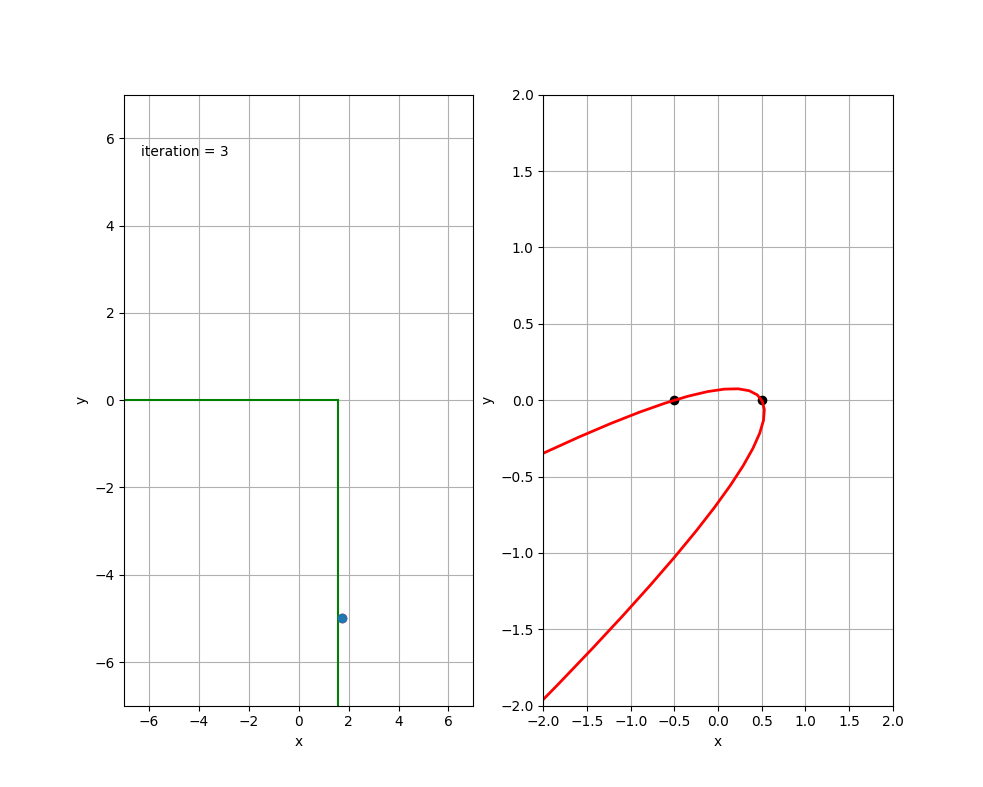

[17.14811648  0.22688352]


In [13]:
%matplotlib notebook
from Visualization.visualization import SubplotAnimationPositioning

ani = SubplotAnimation(results,
                       parameterSpaceMetrics,
                       perturbationMagnitudes, 
                       targetParameter)

ani.show()

In [11]:
from Continuation.StandardContinuation.StepSizeAdaptiveContinuation import StepSizeAdaptiveContinuation

# Instantiate continuation object
standardContinuation = StepSizeAdaptiveContinuation(problem,
                                            initialSolution,
                                            initialParameter,
                                            targetParameter)

standardContinuationResults = standardContinuation.Traverse()


Compiling cost function...
Computing gradient of cost function...
Computing Hessian of cost function...



========== New continuation problem ==========

----- Step Size Selection-----

Initial stepSize = 0.1

NextObj = 0.08535202588564006

NextGrad = 1.2327630093222135


Potential new step size = 0.13333333333333333

NextObj = 0.2718577633322848

NextGrad = 2.4205506369509884


Potential new step size = 0.17777777777777778

NextObj = 0.9381683336124724

NextGrad = 4.899609617864958


Potential new step size = 0.23703703703703705

NextObj = 2.651040879079349

NextGrad = 7.123992914618277


Potential new step size = 0.3160493827160494

NextObj = 6.559193207396911

NextGrad = 13.890605562258646

 --> Objective function tolerance exceeded.


Next step size = 0.23703703703703705


----- Step 1, L = 0.23703703703703705 -----

Compiling cost function...
Computing gradient of cost function...
Computing Hessian of cost function...
Optimizing...
                                            f: +

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


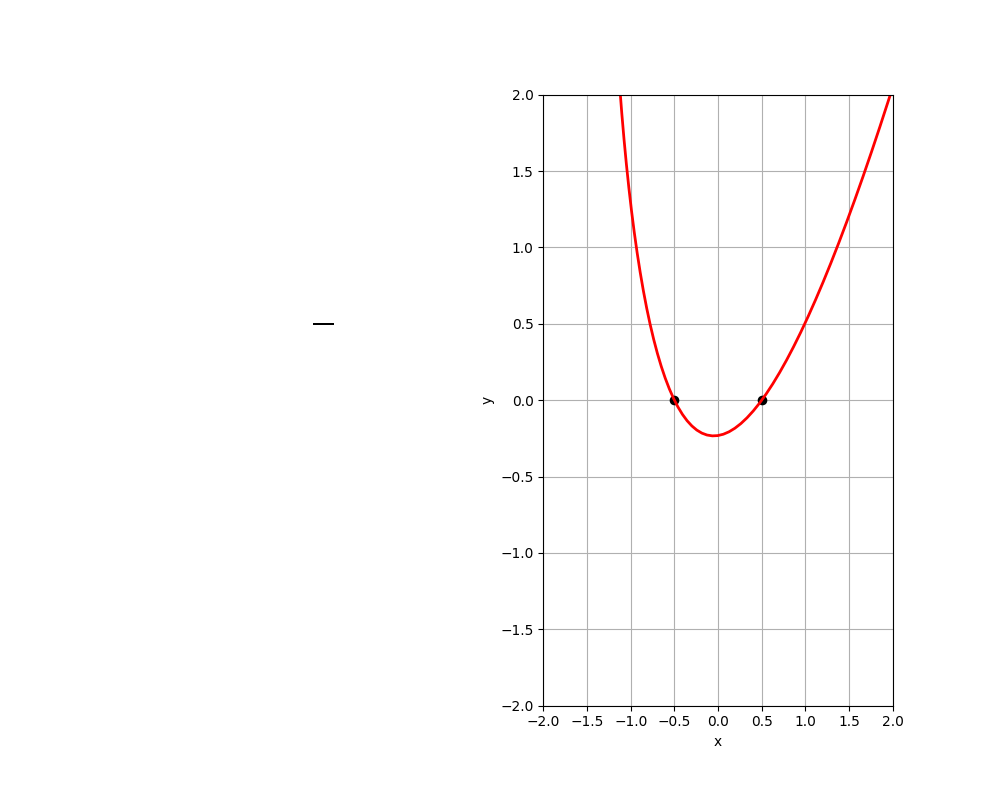

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

class SubplotAnimationPositioning(animation.TimedAnimation):
    def __init__(self, results, targetParameter):
        self.solutions = [S[:len(S)] for (a, S) in results]
        self.parameters = [S[-1] for (a, S) in results]

        self.xParameters = [x for (x, y) in self.parameters]
        self.yParameters = [y for (x, y) in self.parameters]

        fig = plt.figure(figsize=(10, 8), dpi=100)
        self.ax1 = fig.add_subplot(1, 2, 2)
        self.ax2 = fig.add_subplot(1, 2, 1)

        self.ax1.set_xlabel('x')
        self.ax1.set_ylabel('y')
        self.ax1.set_xlim(-2., 2.)
        self.ax1.set_ylim(-2., 2.)

        self.ax2.set_xlabel('x')
        self.ax2.set_ylabel('y')
        self.ax2.set_xlim(-4, 4)
        self.ax2.set_ylim(-4, 4)

        self.ax1.grid()
        self.ax2.grid()

        self.ax2.plot(targetParameter[0], targetParameter[1], 'ro')

        self.linePoints, = self.ax1.plot([], [], 'ko', lw=2)
        self.lineCurve, = self.ax1.plot([], [], 'r-', lw=2)
        self.line, = self.ax2.plot([], [], 'o', lw=2)
        self.time_template = 'iteration = %.1i'
        self.time_text = self.ax2.text(0.05, 0.9, '', transform=self.ax2.transAxes)

        self.targetParameter = targetParameter

        self.draw_curve(0)

        animation.TimedAnimation.__init__(self, fig, interval=1200, blit=False, repeat=True)

    def _draw_frame(self, framedata):

        # draw perturbation vector
        if framedata + 1 < len(self.xParameters):
            dx = self.xParameters[framedata + 1] - self.xParameters[framedata]
            dy = self.yParameters[framedata + 1] - self.yParameters[framedata]
            self.ax2.arrow(self.xParameters[framedata], self.yParameters[framedata], dx, dy)

        self.draw_curve(framedata)

        # draw new parameter value in parameter space
        thisx = self.xParameters[framedata]
        thisy = self.yParameters[framedata]

        self.line.set_data(thisx, thisy)

        # draw number of iteration
        self.time_text.set_text(self.time_template % framedata)

        print("Delta parameter = " + str(self.targetParameter - self.parameters[framedata]))

    def new_frame_seq(self):
        return iter(range(len(self.xParameters)))

    def _init_draw(self):
        self.line.set_data([], [])
        self.lineCurve.set_data([], [])
        self.linePoints.set_data([], [])
        self.time_text.set_text('')

    def draw_curve(self, framedata):
        a = self.yParameters[framedata]

        if framedata == 0:
            solution = self.solutions[0][0]
        else:
            solution = self.solutions[framedata]

        rotationMatrix = solution[0]
        translationVector = solution[1]
        t = solution[2]

        x = np.linspace(-3, 3, 100)
        y = a * x ** 2

        xRotAndTrans = rotationMatrix[0, 0] * x + rotationMatrix[0, 1] * y + translationVector[0]
        yRotAndTrans = rotationMatrix[1, 0] * x + rotationMatrix[1, 1] * y + translationVector[1]

        self.lineCurve.set_data(xRotAndTrans, yRotAndTrans)

        self.linePoints.set_data(
            [rotationMatrix[0, 0] * t[0] + rotationMatrix[0, 1] * a * t[0] ** 2 + translationVector[0],
             rotationMatrix[0, 0] * t[1] + rotationMatrix[0, 1] * a * t[1] ** 2 + translationVector[0]],
            [rotationMatrix[1, 0] * t[0] + rotationMatrix[1, 1] * a * t[0] ** 2 + translationVector[1],
             rotationMatrix[1, 0] * t[1] + rotationMatrix[1, 1] * a * t[1] ** 2 + translationVector[1]])

    @staticmethod
    def show():
        plt.show()

ani = SubplotAnimationPositioning(results, targetParameter)

ani.show()

## Define cost function 